<a href="https://colab.research.google.com/github/Anucha780/229352-StatisticalLearning/blob/main/Lab10_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision # For utils.make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
from tqdm.auto import tqdm # For nice progress bars
from sklearn.metrics import accuracy_score

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We will use a dataset of pizza, stead and sushi images ([source](https://donlapark.pages.dev/229352/pizza_steak_sushi.zip))

In [9]:
!wget https://donlapark.pages.dev/229352/pizza_steak_sushi.zip

--2025-09-21 17:19:11--  https://donlapark.pages.dev/229352/pizza_steak_sushi.zip
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.1s    

2025-09-21 17:19:11 (140 MB/s) - ‘pizza_steak_sushi.zip’ saved [15737296/15737296]



In [11]:
!unzip -q pizza_steak_sushi.zip

In [12]:
train_dir = "train"
test_dir = "test"

# Data augmentation

![augmentation](https://miro.medium.com/max/700/0*LR1ZQucYW96prDte)

See more transformations in [Pytorch documentation](https://docs.pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

Class names: ['pizza', 'steak', 'sushi']
Class to index mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}
Number of training samples: 225
Number of testing samples: 75
Number of batches in training DataLoader: 8
Number of batches in testing DataLoader: 1


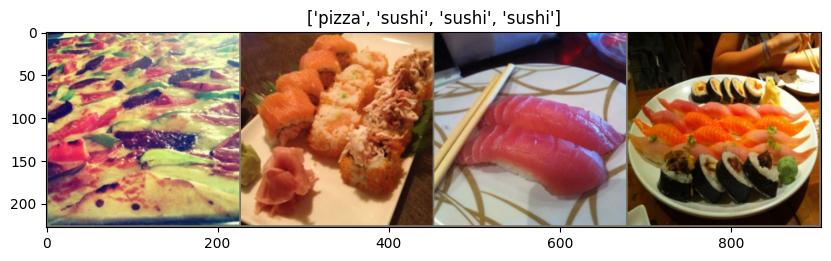

In [14]:
# 1. Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize all images to 224x224
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize pixel values (ImageNet statistics)
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.4)
])

# 2. Create datasets using ImageFolder
train_data = datasets.ImageFolder(root="train", transform=data_transforms) # Write your code here
test_data = datasets.ImageFolder(root="test", transform=data_transforms) # Write your code here

# Get class names and their mapping
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

print(f"Class names: {class_names}")
print(f"Class to index mapping: {class_to_idx}")
print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# 3. Create DataLoaders
BATCH_SIZE = 30 # You can experiment with different batch sizes

train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True) # Write your code here

test_dataloader = DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=False) # Write your code here

print(f"Number of batches in training DataLoader: {len(train_dataloader)}")
print(f"Number of batches in testing DataLoader: {len(test_dataloader)}")

# Let's visualize a sample image and its label
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Undo normalization
    inp = np.clip(inp, 0, 1) # Clip pixel values to [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4]) # Show first 4 images

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
plt.show()

## Part 1: Implement and Train LeNet

LeNet-5 is one of the earliest convolutional neural networks, developed by Yann LeCun et al. in the 1990s. While originally designed for smaller images (like MNIST digits), we will adapt its architecture for our 224x224 pixel images.

![lenet5](http://d2l.ai/_images/lenet.svg)

### LeNet Architecture (Adapted for 224x224 input, 3 output classes):

1.  **Input Layer**: 3x224x224 image (RGB channels).
2.  **Conv1**: ([Conv2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html))
    *   Input Channels: 3
    *   Output Channels: 6
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
3.  **Pool1**: ([MaxPool2d document](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html))
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
4.  **Conv2**:
    *   Input Channels: 6
    *   Output Channels: 16
    *   Kernel Size: 5x5
    *   Stride: 1
    *   Activation: ReLU
5.  **Pool2**:
    *   Type: Max Pooling
    *   Kernel Size: 2x2
    *   Stride: 2
6.  **Flatten**: Flatten the 3D feature maps into a 1D vector.
    *   *Hint*: After Pool2, the feature map size will be `16 * (something) * (something)`. You'll need to calculate this dimension based on the input size and the conv/pool operations.
        *   Input (224x224) -> Conv1 (224-5+1 = 220x220)
        *   Pool1 (220/2 = 110x110)
        *   Conv2 (110-5+1 = 106x106)
        *   Pool2 (106/2 = 53x53)
        *   So, the output of Pool2 will be `16 * 53 * 53`.
7.  **FC1 (Fully Connected 1)**:
    *   Input Features: `16 * 53 * 53`
    *   Output Features: 120
    *   Activation: ReLU
8.  **FC2 (Fully Connected 2)**:
    *   Input Features: 120
    *   Output Features: 84
    *   Activation: ReLU
9.  **Output Layer (FC3)**:
    *   Input Features: 84
    *   Output Features: 3 (for pizza, steak, sushi)

**Your Task:**
1.  Implement the `LeNet` class following the architecture above.
2.  Instantiate the model and move it to the `device` (GPU/CPU).
3.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer (`optim.Adam`).
4.  Train the LeNet model for a few epochs (e.g., 5-10).
5.  Evaluate its performance on the test set.

In [15]:
class LeNet(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet, self).__init__()
        # Write your code here
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.Linear1 = nn.Linear(110 * 110 * 6, 3)
        self.softmax = nn.Softmax()

    def forward(self, x):
        # Write your code here
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.Linear1(x)
        x = self.softmax(x)

        return x

lenet_model = LeNet(num_classes=3)

In [16]:
lenet_model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=72600, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)

In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)

In [18]:
# Training loop function (to be reused)
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    print(f"\n--- Training {model.__class__.__name__} for {num_epochs} epochs ---")
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Training phase
        model.train() # Set model to training mode
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_dataloader:
            # 1. Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)

            # 2. Zero the gradient
            optimizer.zero_grad()

            # 3. Make predictions
            outputs = model(inputs)

            # 4. Calculate the loss
            loss = criterion(outputs, labels)

            # 5. Calculate the gradients
            loss.backward()

            # 6. Update model's parameters
            optimizer.step()

            # Calculate total loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dataloader.dataset)
        epoch_train_acc = train_correct / train_total
        results["train_loss"].append(epoch_train_loss)
        results["train_acc"].append(epoch_train_acc)

        # Evaluation phase
        model.eval() # Set model to evaluation mode
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad(): # Disable gradient calculation for evaluation
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_dataloader.dataset)
        epoch_test_acc = test_correct / test_total
        results["test_loss"].append(epoch_test_loss)
        results["test_acc"].append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.4f}")
    return results

In [19]:
# Instantiate LeNet model
lenet_model = LeNet(num_classes=len(class_names)).to(device)
optimizer = optim.Adam(lenet_model.parameters(), lr=0.001)
print(lenet_model)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=72600, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)


In [20]:
# Train the LeNet model
lenet_results = train_model(lenet_model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10)


--- Training LeNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/10 - Train Loss: 1.1634, Train Acc: 0.3556 | Test Loss: 1.1780, Test Acc: 0.3733
Epoch 2/10 - Train Loss: 1.0899, Train Acc: 0.4578 | Test Loss: 1.1410, Test Acc: 0.4000
Epoch 3/10 - Train Loss: 1.0383, Train Acc: 0.5111 | Test Loss: 1.1246, Test Acc: 0.4267
Epoch 4/10 - Train Loss: 1.0689, Train Acc: 0.4800 | Test Loss: 1.1779, Test Acc: 0.3733
Epoch 5/10 - Train Loss: 1.0330, Train Acc: 0.5156 | Test Loss: 1.1073, Test Acc: 0.4400
Epoch 6/10 - Train Loss: 1.0103, Train Acc: 0.5422 | Test Loss: 1.1788, Test Acc: 0.3733
Epoch 7/10 - Train Loss: 1.0426, Train Acc: 0.5067 | Test Loss: 1.1925, Test Acc: 0.3600
Epoch 8/10 - Train Loss: 1.0242, Train Acc: 0.5289 | Test Loss: 1.1656, Test Acc: 0.3867
Epoch 9/10 - Train Loss: 0.9824, Train Acc: 0.5689 | Test Loss: 1.1739, Test Acc: 0.3733
Epoch 10/10 - Train Loss: 0.9857, Train Acc: 0.5644 | Test Loss: 1.1887, Test Acc: 0.3600


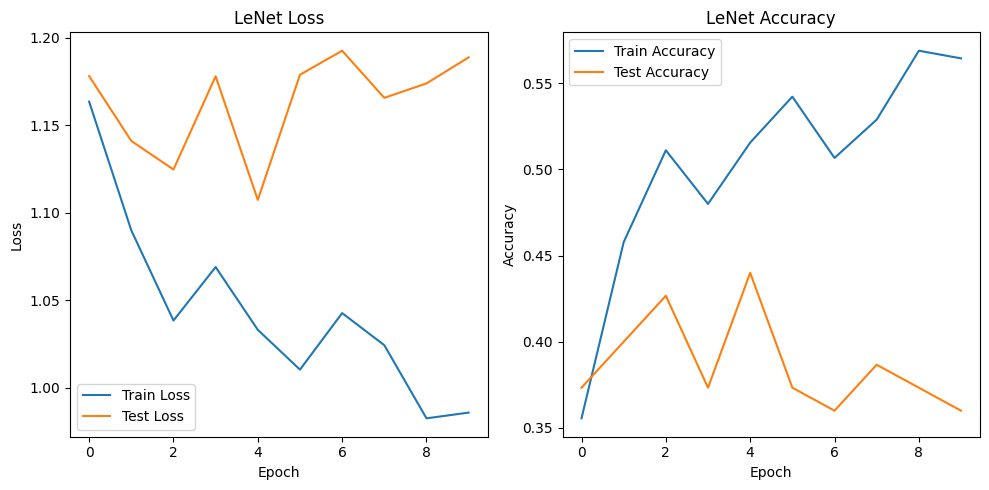

In [21]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lenet_results['train_loss'], label='Train Loss')
plt.plot(lenet_results['test_loss'], label='Test Loss')
plt.title('LeNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lenet_results['train_acc'], label='Train Accuracy')
plt.plot(lenet_results['test_acc'], label='Test Accuracy')
plt.title('LeNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 1:
1.  How did the LeNet model perform on the test set? What was its final test accuracy?
    *   **Your Answer:**

## Part 2: Transfer Learning

Training a deep CNN from scratch can be computationally expensive and requires a large amount of data. Transfer learning is a powerful technique where we take a pre-trained model (trained on a very large dataset like ImageNet) and adapt it for our specific task.

Here, we will use `EfficientNet_B0` from `torchvision.models`, which is a powerful and efficient model.

[List of pretrained models in Pytorch](https://docs.pytorch.org/vision/main/models.html#classification)

**Your Task:**
1.  Load a pre-trained `EfficientNet_B0` model.
2.  "Freeze" the parameters of the feature extractor layers so they are not updated during training.
3.  Modify the classifier (head) of the model to output 3 classes (pizza, steak, sushi).
    *   *Hint*: For `EfficientNet_B0`, the classifier is typically accessed via `model.classifier`. You'll need to replace its last layer.
4.  Instantiate the modified model and move it to the `device`.
5.  Define the loss function (`nn.CrossEntropyLoss`) and optimizer.
    *   *Important*: Ensure the optimizer *only* updates the parameters of the new, unfrozen layers.
6.  Train the transfer learning model for a few epochs (e.g., 5-10).
7.  Evaluate its performance on the test set.

In [22]:
# 1. Load a pre-trained EfficientNet_B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


In [26]:
efficientnet_model.classifier[1]

Linear(in_features=1280, out_features=3, bias=True)

In [24]:
# 2. Freeze all parameters in the feature extractor part
#### Write your code here
for param in efficientnet_model.parameters():
    param.requires_grad = False
    print(param)
    print(param.requires_grad)

# 3 Change the head (the classifier) of the model
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
)

efficientnet_model = efficientnet_model.to(device)
print("\nModified EfficientNet_B0 classifier head:")
print(efficientnet_model.classifier)

Streaming output truncated to the last 5000 lines.
        1.5342, 1.1464, 1.0942, 1.1962, 2.6078, 1.8670, 1.5581, 0.8618, 1.5374,
        1.6099, 1.7310, 1.9300, 2.7727, 1.9631, 0.9407, 3.5573, 1.5228, 0.6219,
        0.5631, 1.1278, 1.3511, 2.2372, 3.1711, 1.0573, 2.2662, 1.5915, 3.0021,
        1.0257, 2.0964, 0.7559, 1.9633, 1.8754, 1.6152, 1.5938, 1.4374, 1.9589,
        0.5203, 1.7716, 0.9641, 1.5839, 1.4735, 2.4076, 3.4569, 1.5347, 1.5699,
        1.5555, 1.0383, 1.2735, 0.8855, 1.0778, 1.3137, 1.7895, 0.7615, 1.2754,
        2.6068, 1.4833, 2.0652, 2.5828, 2.4607, 0.7122, 1.3467, 0.3880, 1.5801,
        0.4474, 1.3907, 1.8724, 1.0855, 1.5896, 0.9181, 1.4167, 2.0609, 0.9181,
        1.2086, 1.5582, 1.5903, 1.0672, 2.1871, 1.8870, 0.8926, 0.6163, 0.7880,
        0.8880, 1.6145, 2.1387, 1.4138, 1.5993, 0.4246, 1.6524, 1.1027, 1.6044,
        2.3706, 1.8103, 2.1222, 1.8413, 0.9609, 1.3015, 1.2308, 2.2654, 1.3480,
        0.9842, 1.1505, 1.5170, 1.5231, 1.9285, 1.1464, 1.1129, 0.366

In [27]:
# Check which parameters are being trained
print("\nParameters to be trained:")
params_to_update = []
for name, param in efficientnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)


Parameters to be trained:
classifier.1.weight
classifier.1.bias


In [28]:
# 4. Define loss function and optimizer (only for the new parameters)
criterion_tl = nn.CrossEntropyLoss() # Write your code here
optimizer_tl = optim.Adam(params_to_update, lr=0.001) # Write your code here

In [29]:
# 5. Train the transfer learning model
efficientnet_results = train_model(efficientnet_model, train_dataloader, test_dataloader, criterion_tl, optimizer_tl, num_epochs=10)


--- Training EfficientNet for 10 epochs ---


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 1.0242, Train Acc: 0.5067 | Test Loss: 0.8399, Test Acc: 0.8267
Epoch 2/10 - Train Loss: 0.8354, Train Acc: 0.7911 | Test Loss: 0.7185, Test Acc: 0.8800
Epoch 3/10 - Train Loss: 0.6946, Train Acc: 0.8622 | Test Loss: 0.6803, Test Acc: 0.8400
Epoch 4/10 - Train Loss: 0.6241, Train Acc: 0.8400 | Test Loss: 0.6203, Test Acc: 0.8533
Epoch 5/10 - Train Loss: 0.5782, Train Acc: 0.8533 | Test Loss: 0.5526, Test Acc: 0.8933
Epoch 6/10 - Train Loss: 0.5004, Train Acc: 0.8978 | Test Loss: 0.5231, Test Acc: 0.9067
Epoch 7/10 - Train Loss: 0.4600, Train Acc: 0.8889 | Test Loss: 0.4685, Test Acc: 0.8667
Epoch 8/10 - Train Loss: 0.4503, Train Acc: 0.8933 | Test Loss: 0.4511, Test Acc: 0.8800
Epoch 9/10 - Train Loss: 0.4134, Train Acc: 0.9067 | Test Loss: 0.4655, Test Acc: 0.8533
Epoch 10/10 - Train Loss: 0.3822, Train Acc: 0.9422 | Test Loss: 0.4386, Test Acc: 0.9067


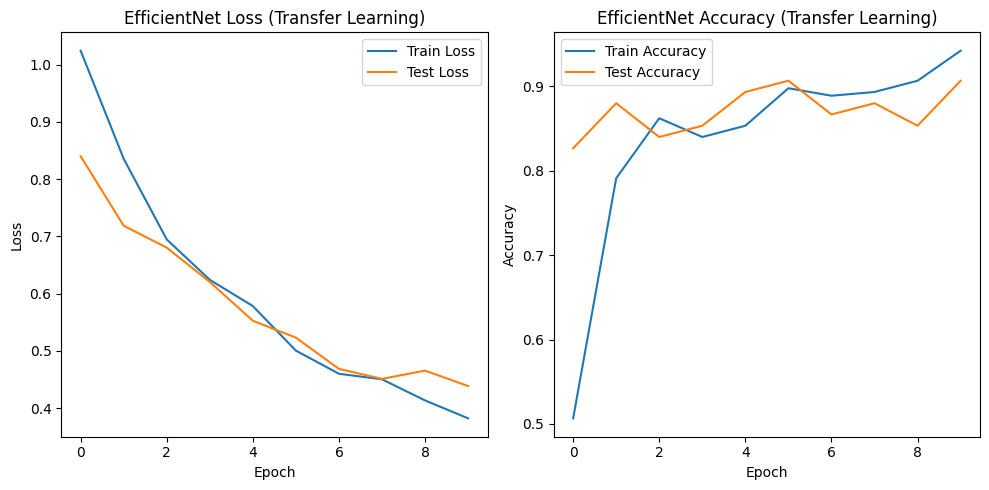

In [30]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(efficientnet_results['train_loss'], label='Train Loss')
plt.plot(efficientnet_results['test_loss'], label='Test Loss')
plt.title('EfficientNet Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(efficientnet_results['train_acc'], label='Train Accuracy')
plt.plot(efficientnet_results['test_acc'], label='Test Accuracy')
plt.title('EfficientNet Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Questions for Part 2:
1.  Compare the performance of the LeNet model (from Part 1) with the transfer learning model (EfficientNet_B0). Which one performed better and why do you think that is?
    *   **Your Answer: EfficientNet_B0 ดีกว่า เนื่องจากใช้ pre-trained weights จาก ImageNet ที่เรียนรู้ฟีเจอร์ทั่วไปไว้แล้ว ต่างจาก LeNet ที่เทรนจากศูนย์**
2.  Explain the concept of "freezing" layers in transfer learning. Why is it done, and what are its benefits?
    *   **Your Answer: Freezing layers คือการล็อคน้ำหนักบางชั้นไม่ให้เรียนรู้ใหม่ เพื่อเก็บความรู้เดิมและลด overfitting นอกจากนี้ยังช่วยประหยัดเวลาและทรัพยากร**
3.  What challenges might arise when using transfer learning on a dataset that is significantly different from the dataset the pre-trained model was originally trained on (e.g., medical images vs. ImageNet)?
    *   **Your Answer: อาจเกิดปัญหา ฟีเจอร์ไม่ตรง ทำให้ค่า accuracy ต่ำ จึงต้องทำการ tune เพิ่ม**
4.  Choose 3 images from the test set. Display the images and show their predicted classes.

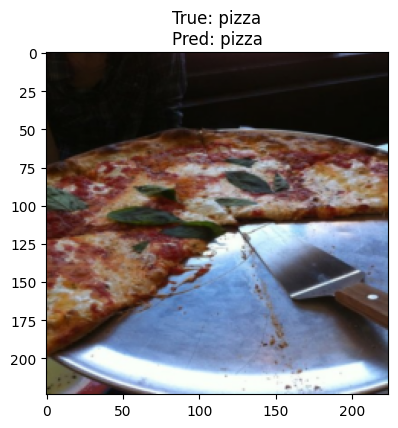

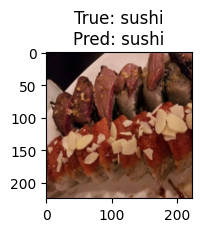

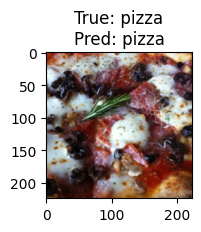

<Figure size 640x480 with 0 Axes>

In [33]:
# Choose 3 images from the test set. Display the images and show their predicted classes.

test_inputs, test_labels = next(iter(test_dataloader))
test_inputs = test_inputs.to(device)

efficientnet_model.eval()
with torch.no_grad():
    test_outputs = efficientnet_model(test_inputs)
    _, test_preds = torch.max(test_outputs, 1)

np.random.seed(42)
random_indices = np.random.choice(len(test_data), 3, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 3, i + 1)
    imshow(test_inputs[idx].cpu(), title=f"True: {class_names[test_labels[idx]]}\nPred: {class_names[test_preds[idx]]}")
plt.tight_layout()
plt.show()

In [35]:
# Example of making prediction on an image

x = torch.rand(1, 3, 224, 224)  # an image

prediction = efficientnet_model(x.to(device))

torch.argmax(prediction)



tensor(2, device='cuda:0')

$$ P(y=0 | x) = \frac{e^{0.1164}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=1 | x) = \frac{e^{-0.0953}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$

$$ P(y=2 | x) = \frac{e^{0.0978}}{e^{0.1164} + e^{-0.0953} + e^{0.0978}}. $$